<a href="https://colab.research.google.com/github/monkeyflwr/Master-Dashboard/blob/main/PoC_of_dis_and_misinformation_detection_dashboard_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installlation and import of packages

In [1]:
pip install feedparser requests nltk pandas numpy matplotlib seaborn wordcloud transformers dash dash-bootstrap-components jupyter-dash pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00


In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=9ebc329a17315f167210c760bd23299bf4ccb96d769778fb89c2dabdcd6234ed
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [3]:
import pandas as pd
import numpy as np
from getpass import getpass
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
import feedparser
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification, BertModel, BertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, BertConfig
import time
import datetime
from datetime import datetime, timedelta
import random
import tensorflow as tf
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
from pyngrok import ngrok
import plotly.express as px
from google.colab import drive
drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-3-13c957599c89>:35: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-13c957599c89>:36: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


#Google Fact Check Exporer API - Data extraction

Below we define the key variables needed for Google Fact Check Explorer API extraction and data processing. Please run the code below and insert your API_key. Instructions on how to set an API key can be found here: https://support.google.com/googleapi/answer/6158862

In [11]:
API_key = getpass('Enter the API key value: ')

Enter the API key value: ··········


In [12]:
source =['Quint'
         ,'Newschecker'
         ,'PolitiFact' 
         ,'Snopes'
         ,'Newsmobile'
         ,'usatoday.com'
         ,'POLYGRAPH.info'
         ,'rappler.com'
         ,'THIP Media'
         ,'FACTLY'
         ,'Lead Stories'
         ]
url = 'https://factchecktools.googleapis.com/v1alpha1/claims:search'

trust = ['true', 'mostly true', 'accurate', 'this is accurate', 'this is correct', 'largerly accurate'] # 0 
no_trust = ['false', ' mostly false', 'half true', 'half false', 'pants on fire','wrong','inaccurate','false context','misattributed','partly false','scam','likely false','this is wrong','false context/false', 'fabricated','mixture','misleading', 'needs context','missing context','unproven','no evidence','miscaptioned','manipulated media','imposter content','exaggerated'] #1

The function **getGoogle_FactCheck_API_data** that retrieves data from the website in json format and normalizes it to pandas dataframe. Below we can set a maximum number of days. Based on this number the function retrieves the news reviews from fact-checking sources for the amount of days specified in *maxDaysAge* variable. If 5 is chosen, the data for last 5 days will be extracted.

In [6]:
maxDaysAge = 5

In [7]:
def getGoogle_FactCheck_API_data(source, dataframe):
  temp_df = dataframe

  for i in source:
    payload = {
        'key': API_key,
        'query':i,
        'languageCode': 'en',
        'pageSize':'10000',
        'maxAgeDays': maxDaysAge
    }
    response = requests.get(url, params=payload)
    Google_Fact_Check_API_json = response.text
    result = json.loads(Google_Fact_Check_API_json)

    try:
      Google_Fact_Check_API_df = pd.json_normalize(
        data=result["claims"], record_path = [ "claimReview"], errors = 'ignore', 
        meta = ["text","claimant", "claimDate"]
        )
      
      #Droping unused columns from data retieved by API
      Google_Fact_Check_API_df.drop(['languageCode', 'publisher.name', 'title'], axis=1, inplace=True)

      #Converting object to date for columns reviewDate and claimDate
      Google_Fact_Check_API_df['reviewDate'] = pd.to_datetime(Google_Fact_Check_API_df['reviewDate'])
      Google_Fact_Check_API_df['claimDate'] = pd.to_datetime(Google_Fact_Check_API_df['claimDate'])

      #making all letters in column rating lowercase
      Google_Fact_Check_API_df['textualRating']=Google_Fact_Check_API_df['textualRating'].map(str.lower)

      # concatinating dataframes
      temp_df = pd.concat([temp_df, Google_Fact_Check_API_df], axis=0)

      #removing duplicates
      temp_df = temp_df.drop_duplicates(subset = 'url')

    except KeyError:
      # in case no claims found in source
      pass

  temp_df.reset_index(inplace = True, drop = True)
  
  return temp_df


The function that adjusts the rating taking variablels trust and no trust from the dataframe and assigning them binary values 1 and 0:

In [ ]:
def adjust_rating(dataframe):
  dataframe.loc[(dataframe.textualRating.isin(trust)), 'trustIndex'] = 0
  dataframe.loc[(dataframe.textualRating.isin(no_trust)), 'trustIndex'] = 1
  dataframe.dropna(subset=['trustIndex'], axis=0, inplace=True)

In this step we are creating a new database and populating it with data retrieved from Google Fact Check Exporer via API

In [8]:
df_API = pd.DataFrame()
df_API = getGoogle_FactCheck_API_data(source, df_API)

We change the type of the'textualRating' variable, create a new column 'trustIndex' and apply the function that will create create a binary variable 0 and 1 (trust and no trust) out of 'textualRating' column.

In [ ]:
df_API['textualRating'] = df_API['textualRating'].astype(str).str.replace('.', '')
df_API['trustIndex'] = None
adjust_rating(df_API)

<ipython-input-8-c16230d67e92>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_API['textualRating'] = df_API['textualRating'].astype(str).str.replace('.', '')


This step should be skipped, if you run the code for the first time.

In this step we upload the previously created version of the dataset retrieved from Google Fact Check Explorer. New news reviews were added to this dataset regularly since the end of January 2022. It is located on author's local drive.

In [ ]:
df_API_saved = pd.read_csv('/content/gdrive/MyDrive/Google_FactCheckAPI_df.csv')
df_API_saved = df_API_saved.drop('Unnamed: 0', axis=1)

Now we join our old dataset with the new one recently retrieved from Google Fact Check Exporer with data for last 5 days. This step must be skipped if this is the first time you run this code.

In [ ]:
df_API = pd.concat([df_API_saved, df_API], axis=0)
df_API = df_API.drop_duplicates(subset = 'url')
df_API.reset_index(inplace = True, drop = True)
df_API = df_API.drop({'publisher.site'}, axis=1)

In [ ]:
df_API

,url,reviewDate,textualRating,text,claimant,claimDate,trustIndex
0,https://www.thequint.com/news/webqoof/old-edit...,2023-01-04,false,Video shows Jane Goodall advocating depopulati...,"Facebook,Twitter",2023-01-04,1
1,https://www.thequint.com/news/webqoof/old-imag...,2022-12-27,false,This picture is recent and shows a massive tra...,"Facebook,Twitter,Dainik Bhaskar,TV9 Bharatvars...",2022-12-27,1
2,https://www.thequint.com/news/webqoof/video-of...,2023-01-05,false,Video of a Muslim man kicking a photo of Godde...,Social Media,2023-01-05,1
3,https://www.thequint.com/news/webqoof/mohan-bh...,2022-10-08,false,India could have a religioun-based population ...,Mohan Bhagwat,2022-10-08,1
4,https://www.thequint.com/news/webqoof/pm-modi-...,2022-12-24,false,Prime Minister Narendra Modi wore an embroider...,"Hitendra Pithadiya,Kirti Azad,Twitter",2022-12-24,1
...,...,...,...,...,...,...,...
1952,https://www.polygraph.info/a/fact-check-moscow...,2023-02-08 00:00:00+00:00,misleading,"""The United States and its allies ... have beg...",Sergey Shoigu,2023-02-08 00:00:00+00:00,1
1953,https://www.rappler.com/newsbreak/fact-check/a...,2023-02-08 04:46:18+00:00,false,President Ferdinand Marcos Jr. said that the i...,NaN,2023-02-08 04:46:18+00:00,1
1954,https://www.rappler.com/newsbreak/fact-check/j...,2023-02-07 07:39:00+00:00,false,The Japanese government gave Type 74 battle ta...,NaN,2023-02-07 07:39:00+00:00,1
1955,https://factly.in/old-visuals-of-birds-flying-...,2023-02-07 00:00:00+00:00,false,Visuals showing strange behaviour of birds bef...,SOCIAL MEDIA POST,2023-02-07 00:00:00+00:00,1


In [ ]:
df_API.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            1957 non-null   object
 1   reviewDate     1748 non-null   object
 2   textualRating  1957 non-null   object
 3   text           1957 non-null   object
 4   claimant       1382 non-null   object
 5   claimDate      1445 non-null   object
 6   trustIndex     1957 non-null   object
dtypes: object(7)
memory usage: 107.1+ KB


We are saving this dataset on Google Drive, so it can be refreshed again in a couple of days. Please make sure you add your path.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Google_FactCheckAPI_df.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_API.to_csv(f)

Mounted at /content/drive


# PolitiFact dataset

We export PoitiFact dataset into the notebook. The dataset can be downloaded from Kaggle: https://www.kaggle.com/datasets/rmisra/politifact-fact-check-dataset 

The dataset is in json format therefore we should use read_json pandas function.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PolitiFact_df = pd.read_json('/content/gdrive/MyDrive/politifact_factcheck_data.json', lines=True)

We are checking the oldest and the most recent dates of statements and fact-checking review in PolitiFact dataset. From the code, the time coverage of the dataset is Jan 2013 - Sept 2021.

In [ ]:
a =PolitiFact_df["statement_date"]. max()
b =PolitiFact_df["statement_date"]. min() 
c =PolitiFact_df["factcheck_date"]. min()
d = PolitiFact_df["factcheck_date"]. max() 
print(a ,b ,c ,d)

9/9/2021 1/1/2013 1/1/2011 9/9/2021


This dataset has no missing values.

In [ ]:
PolitiFact_df.isna().sum()

verdict                    0
statement_originator       0
statement                  0
statement_date             0
statement_source           0
factchecker                0
factcheck_date             0
factcheck_analysis_link    0
dtype: int64

We would like to have a high-level overview of this dataset. For this we need to create functions that help us to visualize this data.

In [ ]:
def plot_sns_chart(dataframe, y_axis, class_separator=None, width, height, 
                   font_scale=2, title = 'Title has not been set',
                   xlabel_title="Xlabel title not been set", ylabel_title="Ylabel title not been set"):
    plt.rcParams['figure.figsize'] = [width, height]
    sns.color_palette("flare")
    sns.set(font_scale=font_scale)
    g = sns.countplot(y=y_axis, hue=class_separator, data=dataframe)
    g.set(xlabel=xlabel_title, ylabel=ylabel_title)
    g.set_title(title)
    total = float(len(dataframe))
    margin = 0.0025
    for patch in g.patches:
        percentage = ' {:.1f}%'.format(100 * patch.get_width() / total)
        x = patch.get_width() + (patch.get_width() * margin)
        y = patch.get_y() + (patch.get_height() / 2) 
        g.annotate(percentage, (x, y), va='center') 

We are creating a figure that will show us the distribution of the verdict variable in the dataset. Most of the entries in the dataset (26.6%) are false.

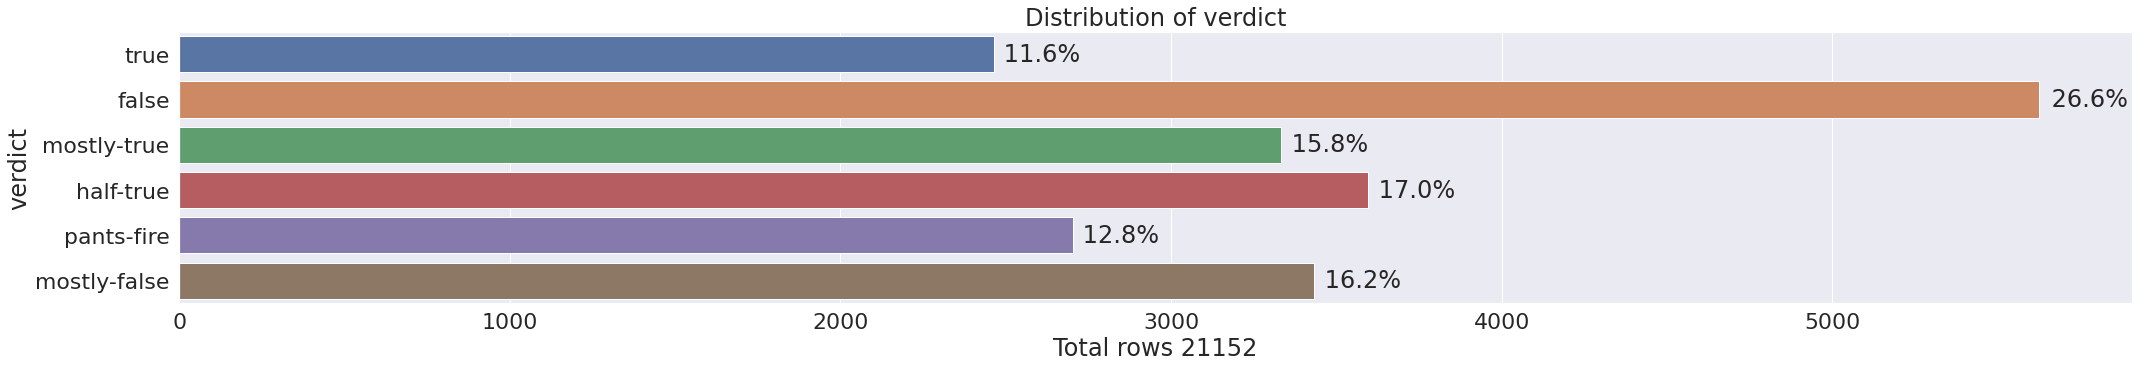

In [ ]:
plot_sns_chart(PolitiFact_df, 'verdict', width=35.0, height=5.0, 
               title=f'Distribution of verdict',
               ylabel_title='verdict', 
               xlabel_title=f'Total rows {PolitiFact_df.shape[0]}')

Below we are producing a word cloud graph. The size of the word correlates with how frequently this word appears in the dataset.

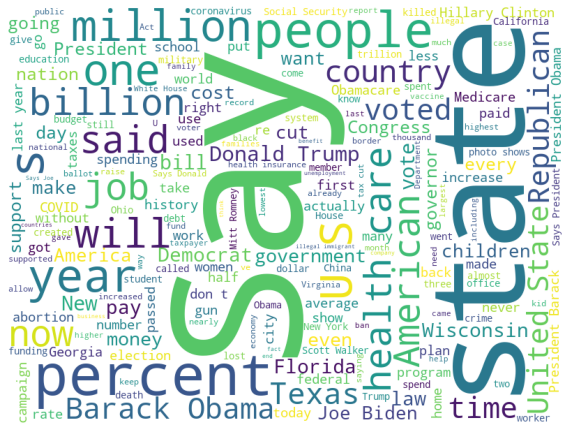

In [ ]:
wordcloud = WordCloud( background_color='white', width=800, height=600)
text_cloud = wordcloud.generate(' '.join(PolitiFact_df['statement']))
plt.figure(figsize=(10,15))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

We would like to have a word cloud for words from fake news only.

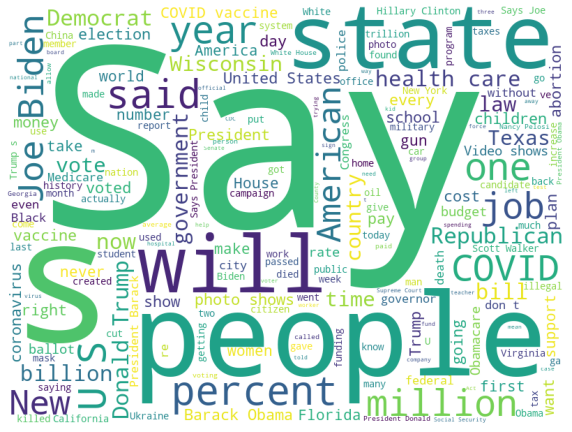

In [ ]:
false_news = ' '.join(PolitiFact_df[PolitiFact_df['verdict']=='false']['statement']) 
wc = wordcloud.generate(false_news)
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

Now we create a word cloud of the most popular words in true news.

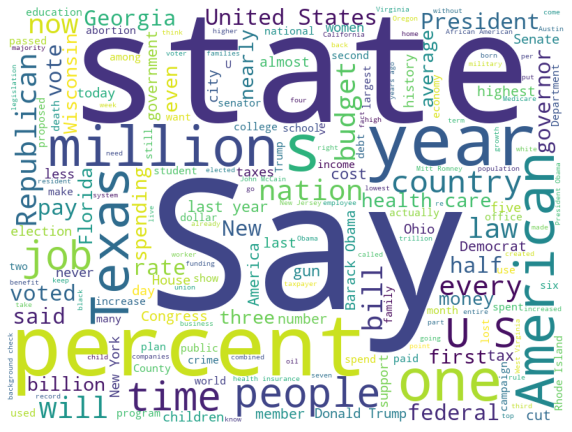

In [ ]:
true_news = ' '.join(PolitiFact_df[PolitiFact_df['verdict']=='true']['statement']) 
wc = wordcloud.generate(true_news)
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.show()

The code below will produce a figure with the distribution of news in the dataset per source. The top 3 most sources in PolitiFact dataset are (media company) news, social media, and speech.

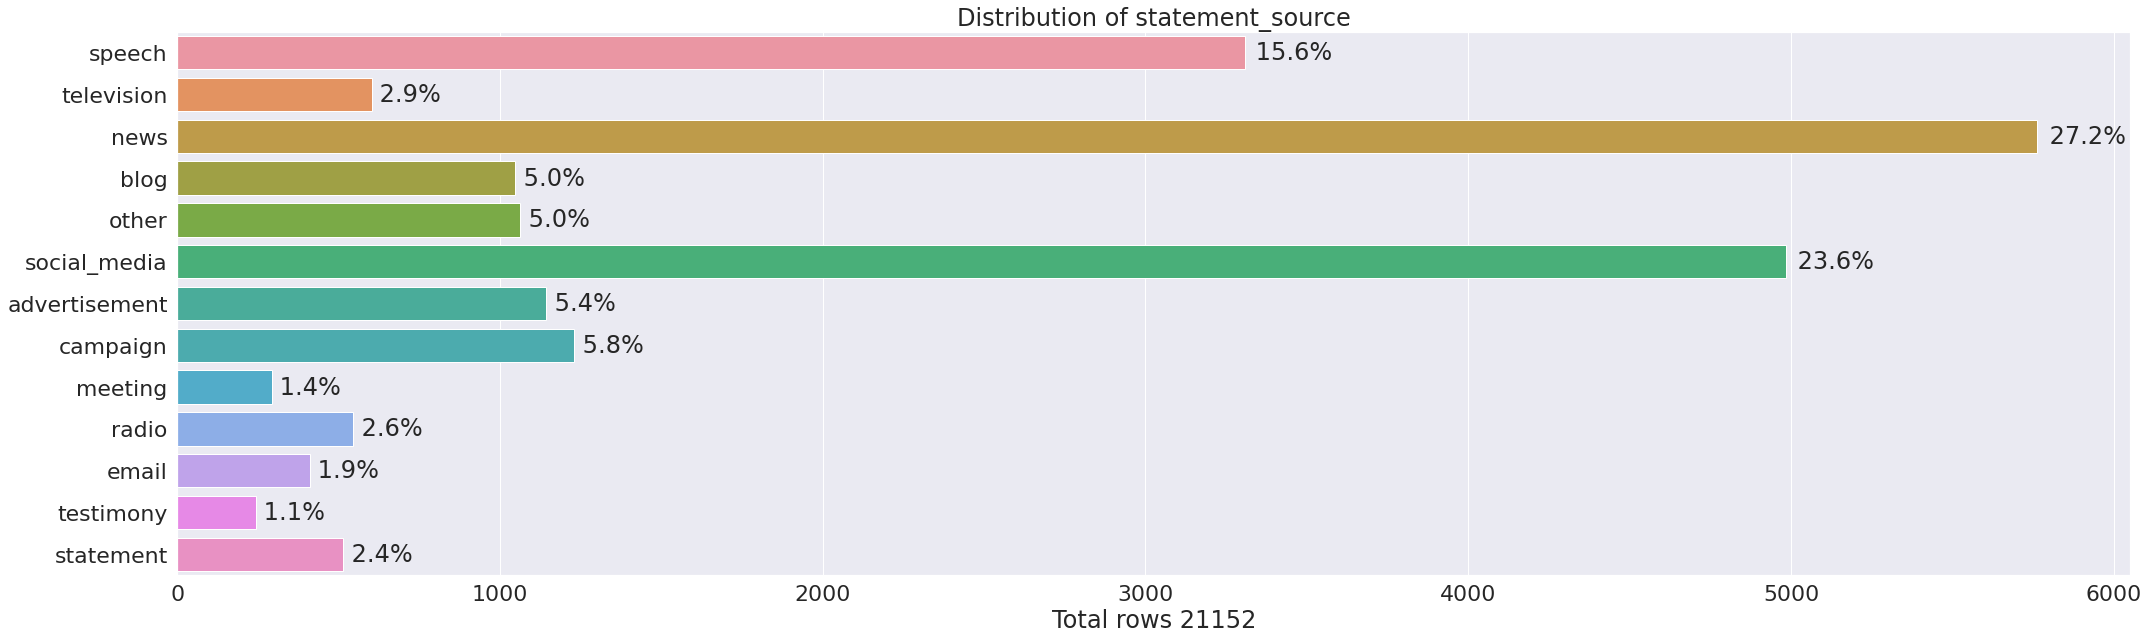

In [ ]:
plot_sns_chart(PolitiFact_df, 'statement_source', width=35.0, height=10.0, 
               title=f'Distribution of statement_source',
               ylabel_title='', 
               xlabel_title=f'Total rows {PolitiFact_df.shape[0]}')

The graph below shows the distribution of news' verdicts per source. We can observe that most of the fake news comes from social media.

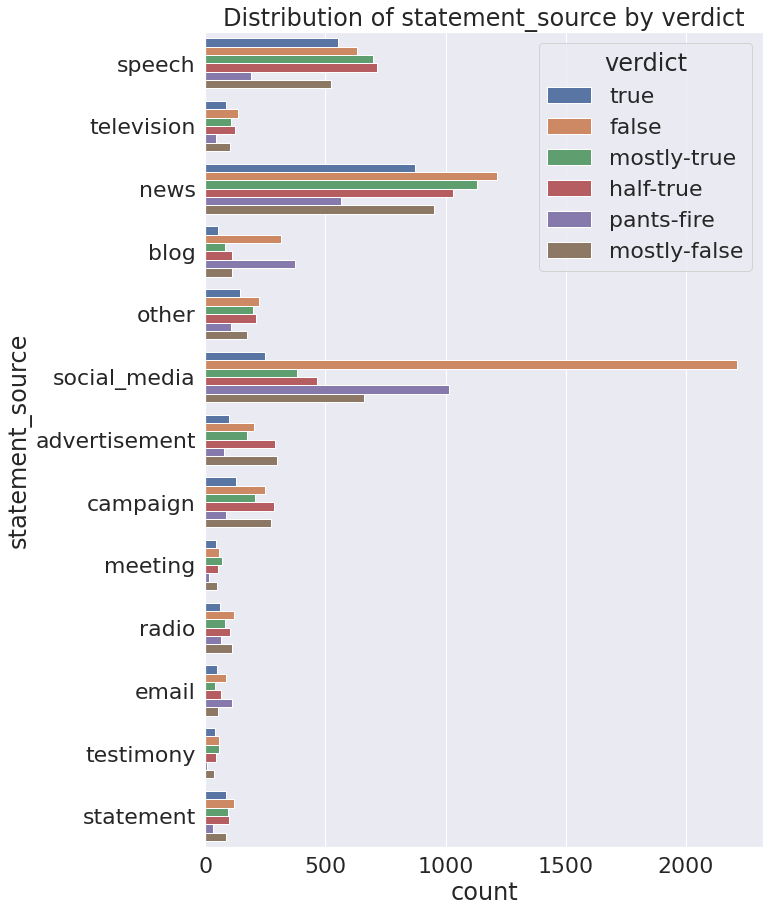

In [ ]:
plt.figure(figsize=(10,15))
plt.title("Distribution of statement_source by verdict")
sns.countplot(data=PolitiFact_df, y="statement_source", hue="verdict")

This code renames columns in the dataset.

In [ ]:
trust = ['true', 'mostly-true'] # 0
no_trust = ['false', 'mostly-false', 'half-true', 'half-false', 'pants-fire'] #1

PolitiFact_df['trustIndex'] = None
PolitiFact_df.rename(columns = {'verdict':'textualRating'}, inplace = True)
PolitiFact_df.rename(columns = {'factcheck_analysis_link':'url'}, inplace = True)
PolitiFact_df.rename(columns = {'factcheck_date':'reviewDate'}, inplace = True)
PolitiFact_df.rename(columns = {'statement':'text'}, inplace = True)
PolitiFact_df.rename(columns = {'statement_originator':'claimant'}, inplace = True)
PolitiFact_df.rename(columns = {'statement_date':'claimDate'}, inplace = True)

Now running the function that was created in the previous part, that changes the trustIndex into 1 and 0.

In [ ]:
adjust_rating(PolitiFact_df)

This figure shows an imbalance in PolitiFact dataset. Usually, data scientists try to avoid data imbalance applying different techniques. As we are going to use the BERT model for our analysis, which deals very well with data imbalance, we skip this part. 

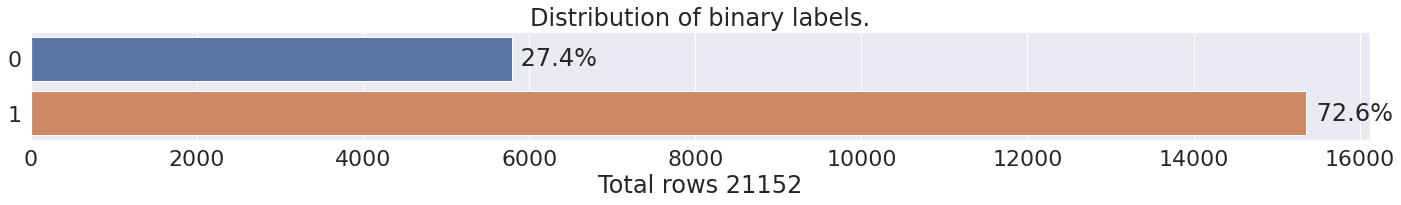

In [ ]:
plot_sns_chart(PolitiFact_df, 'trustIndex', width=24.0, height=2.0, 
               title=f'Distribution of binary labels.',
               ylabel_title='', 
               xlabel_title=f'Total rows {PolitiFact_df.shape[0]}')

Now we combine PolitiFact dataset with data retrieved from Google Fact Check Explorer. Then perform some data cleaning.

In [ ]:
df = pd.concat([PolitiFact_df, df_API], axis=0)
df = df.drop_duplicates(subset = 'text')
df.reset_index(inplace = True, drop = True)
df = df.drop({'claimDate', 'reviewDate', 'url', 'textualRating'}, axis=1)
df["trustIndex"] = df["trustIndex"].astype(str).astype(int)
pd.options.mode.use_inf_as_na = True
df["text"] = df["text"].astype(str)
df["claimant"] = df["claimant"].astype(str)

The head of the final dataset and some data information about it.

In [ ]:
df.head(5)

,claimant,text,statement_source,factchecker,trustIndex
0,Barack Obama,John McCain opposed bankruptcy protections for...,speech,Adriel Bettelheim,0
1,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",television,Yacob Reyes,1
2,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",news,Clay Wirestone,0
3,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",blog,Madison Czopek,1
4,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",television,Linda Qiu,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22960 entries, 0 to 22959
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   claimant          22960 non-null  object
 1   text              22960 non-null  object
 2   statement_source  21139 non-null  object
 3   factchecker       21139 non-null  object
 4   trustIndex        22960 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 897.0+ KB


# RSS

In this step, we retrieve data from media sources that provide news via RSS. Firstly, we define the list of media channels from which we export data. You can add more URL to this list.

In [ ]:
rss_data =[
    ["https://globalnews.ca/world/feed/", "globalnews"]
    ,["https://globalnews.ca/politics/feed/","globalnews"]
    ,["https://www.themoscowtimes.com/rss/news", "msk times"]
    ,["https://www.rt.com/rss/", "RT"]
    ,["https://lifehacker.com/rss", "lifehacker"]
    ,["https://cdn.feedcontrol.net/8/1114-wioSIX3uu8MEj.xml", "reuters"]
    ,["https://rss.nytimes.com/services/xml/rss/nyt/World.xml", "nytimes"]
    ,["https://news.un.org/feed/subscribe/en/news/all/rss.xml", 'UN']
    ,["http://rss.cnn.com/rss/cnn_latest.rss", "cnn"]
    ,["https://feeds.skynews.com/feeds/rss/politics.xml", "skynews"]
    ,["https://moxie.foxnews.com/google-publisher/politics.xml", "foxnews"]
    ,["https://moxie.foxnews.com/google-publisher/world.xml", "foxnews"]
    ,["http://feeds.bbci.co.uk/news/politics/rss.xml", "bbc"]
     ]

The following function **retrieve_news** retrieves the news from RSS links and returns these columns: title, published and source.

In [ ]:
def retrieve_news(row):
  news_list = feedparser.parse(row[0]).entries
  temp_list = []

  for news in news_list:
    try: 
      temp_list.append({'title': news['title'],
                        'published': news['published'],
                        'source': row[1]})
    except:
      pass

  return temp_list

A function **create_rss_dataframe** produces dataframe out of data retrieved from RSS URLs and combines them in one, filters by date.

In [ ]:
def create_rss_dataframe(rss_data):
  df = pd.DataFrame(columns=['title','published', 'source'])

  for row in rss_data:
    news_list = retrieve_news(row)
    df = df.append(news_list, ignore_index=True)

  df = df.sort_values(by=['published'],ascending=[False])
  return df


Function **cleaning_text**  cleans articles' text from unnecessary syntax, etc.

In [ ]:
def cleaning_text(df,column):
  df[column] = df[column].replace(r'\n\n',' ', regex=True) 
  df[column] = df[column].replace(r'CLICK HERE TO GET THE FOX NEWS APP',' ', regex = True)
  df[column] = df[column].replace(r'CNN —',' ', regex=True)
  df[column] = df[column].replace(r'(CNN) —',' ', regex=True)
  return df

We use our main function that creates RSS dataset and convert date into the format pandas understands.

In [ ]:
df_rss = create_rss_dataframe(rss_data)
df_rss['published'] = pd.to_datetime(df_rss['published'])

We apply **cleaning_text** function to our RSS dataset to do some data cleaning such as removing some HTML syntax, removing additional source names, etc.

In [ ]:
df_rss = cleaning_text(df_rss, "title")
df_rss["title"] = df_rss["title"].astype(str)
df_rss["source"] = df_rss["source"].astype(str)

Overview of data types in RSS dataset.

In [ ]:
df_rss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 486 to 463
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      503 non-null    object
 1   published  503 non-null    object
 2   source     503 non-null    object
dtypes: object(3)
memory usage: 15.7+ KB


The head of the dataset contains the title, source, and date published.

In [ ]:
df_rss.head(5)

,title,published,source
486,Is Gibraltar stuck between a rock and a hard p...,2023-01-25 15:52:40+00:00,bbc
485,PMQs in 70 secs: Starmer and SNP turn up heat ...,2023-01-25 15:19:27+00:00,bbc
496,Political tensions rise over Teesside crab deaths,2023-01-11 22:50:17+00:00,bbc
42,Wish You Were (Not) Here: Pink Floyd's Waters ...,2023-02-08 23:30:00+03:00,msk times
208,12 Unexpected Household Uses for Cling Wrap,2023-02-08 22:30:00+00:00,lifehacker


# Model Building

In this part, we are running 2 models: BERT Base Uncased  (running twice) and BERT Large uncased. The difference comes from the number of parameters and attention heads. BERT Large has 3 times more parameters and we would like to see if the accuracy will be higher for BERT Large applying it to our specific text classification task.

We would like to use GPU as we need it for the model training. GPU is a processor that can be used for complex model training that requires a lot of computational power. 

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


We check if GPU is available in Google Colab and what GPU type is used.

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


We also want to see how the model results will differ if we combine the claimant column with the statement column. For this, we create 2 copies of this dataset, where one will have a column statement combined with column claimant. Later we will review how combining 2 of these columns can impact the model accuracy.

In [ ]:
df_no_claim = df.copy()
df_claim = df.copy()

For dataset where we want to combine text column and claimant column, we run the following code.

In [ ]:
df_claim['statement'] = df_claim.apply(lambda row: row['text'] if isinstance(row['claimant'], float) else row['claimant'] + ": " + row['text'], axis=1)
df_claim = df_claim.drop({'text','claimant'}, axis=1)

## BERT base uncased - dataset without claimant

We create a tokenizer based on BERT Base Uncased model, lowering all letters in the dataset. It is supposed to improve model training and accuracy.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

This is an example of how tokenization transforms data into a BERT-friendly format.

In [ ]:
print(' Original: ', df_no_claim['text'][0])
print('Tokenized: ', tokenizer.tokenize(df_no_claim['text'][0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_no_claim['text'][0])))

 Original:  John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
Tokenized:  ['john', 'mccain', 'opposed', 'bankruptcy', 'protections', 'for', 'families', '"', 'who', 'were', 'only', 'in', 'bankruptcy', 'because', 'of', 'medical', 'expenses', 'they', 'couldn', "'", 't', 'pay', '.', '"']
Token IDs:  [2198, 19186, 4941, 10528, 28548, 2005, 2945, 1000, 2040, 2020, 2069, 1999, 10528, 2138, 1997, 2966, 11727, 2027, 2481, 1005, 1056, 3477, 1012, 1000]


Before we set the maximum length of tokens in each statement for model building, we need to understand what is the maximum length of sentences our data has.

In [ ]:
max_len = 0

for t in df_no_claim["text"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(t, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  114


The code below tokenizes our dataset. We add the necessary for BERT tokens, apply padding, construct attention masks. The output below shows how the sentence from our dataset was converted into token ids.

In [ ]:
statements_no_claim = df_no_claim.text.values
our_labels_no_claim = df_no_claim.trustIndex.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

for s in statements_no_claim:

    encoded_dict = tokenizer.encode_plus(
                        s,                     
                        add_special_tokens = True, 
                        max_length = 114,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',        
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(our_labels_no_claim)

#Check the example of the sentence tokenized
print('Original: ', statements_no_claim[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
Token IDs: tensor([  101,  2198, 19186,  4941, 10528, 28548,  2005,  2945,  1000,  2040,
         2020,  2069,  1999, 10528,  2138,  1997,  2966, 11727,  2027,  2481,
         1005,  1056,  3477,  1012,  1000,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,  

We need to split our dataset into training and validation, to evaluate the model performances and compare the results. We use 80/20 split (80 for train and 20 for validation).

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 split.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Checking the samples
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,368 training samples
4,592 validation samples


In this code snippet, we define the batch size and create data loaders for training and validation sets. We picked batch size 32 as it was described in the paper on BERT.

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In this step, we are loading the model and setting some features like the number of output labels (in our case we set 2, as we have a binary target), if we want a model to return weights and hidden states.

In [ ]:
model_no_claim = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,                  
    output_attentions = False, 
    output_hidden_states = False,
)

model_no_claim.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We get all of the model's parameters as a list of tuples.

In [ ]:
params = list(model_no_claim.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

We are going to use AdamW optimizer for BERT fine-tuning.

In [ ]:
optimizer = AdamW(model_no_claim.parameters(),
                  lr = 2e-5, # learning rate
                  eps = 1e-8 # AdamW epsilon used as a small constant used for numeric stability 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We are setting the number of epochs. Authors of the paper on BERT recommend using epochs 2, 3 or 4. Then we check the number of training steps and set a learning scheduler.

In [ ]:
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

We create a function that will calculate accuracy of our models' predictions.

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

To assess model training time, we add **format_time** function.

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We use the glue code script created by Hugging Face Transformers library. More information can be found here

https://github.com/huggingface/transformers/tree/5bfcd0485ece086ebcbed2d008813037968a9e58

or here:
```
@article{Wolf2019HuggingFacesTS,
  title={HuggingFace's Transformers: State-of-the-art Natural Language Processing},
  author={Thomas Wolf and Lysandre Debut and Victor Sanh and Julien Chaumond and Clement Delangue and Anthony Moi and Pierric Cistac and Tim Rault and R'emi Louf and Morgan Funtowicz and Jamie Brew},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.03771}
}
```



In [ ]:
# Setting the seed value for code reproduction
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model_no_claim.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_no_claim.zero_grad()        

        result = model_no_claim(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_no_claim.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model_no_claim.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            result = model_no_claim(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
        loss = result.loss
        logits = result.logits       
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:00:21.
  Batch    80  of    574.    Elapsed: 0:00:43.
  Batch   120  of    574.    Elapsed: 0:01:05.
  Batch   160  of    574.    Elapsed: 0:01:28.
  Batch   200  of    574.    Elapsed: 0:01:50.
  Batch   240  of    574.    Elapsed: 0:02:12.
  Batch   280  of    574.    Elapsed: 0:02:33.
  Batch   320  of    574.    Elapsed: 0:02:56.
  Batch   360  of    574.    Elapsed: 0:03:18.
  Batch   400  of    574.    Elapsed: 0:03:40.
  Batch   440  of    574.    Elapsed: 0:04:02.
  Batch   480  of    574.    Elapsed: 0:04:24.
  Batch   520  of    574.    Elapsed: 0:04:46.
  Batch   560  of    574.    Elapsed: 0:05:08.

  Average training loss: 0.49
  Training epcoh took: 0:05:15

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.48
  Validation took: 0:00:27

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:00:22.
  Batch    80  of    574.    Elapsed: 0:00:44.
  Batch  

We are saving the model on Google Drive, in case we would like to re-run it on some dataset in the future.

In [ ]:
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/model_BERT_uncased_no_claimant" 
torch.save(model_no_claim.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In this step, we are creating a table to check the training, validation losses and accuracy of the model.

In [ ]:
pd.set_option('precision', 2)
df_stats_bert_uncased_no_claim = pd.DataFrame(data=training_stats)
df_stats_bert_uncased_no_claim = df_stats_bert_uncased_no_claim.set_index('epoch')
df_stats_bert_uncased_no_claim

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.48,0.76,0:05:15,0:00:27
2,0.43,0.49,0.75,0:05:14,0:00:27


We would like to visualize the training and validation losses with the following code.

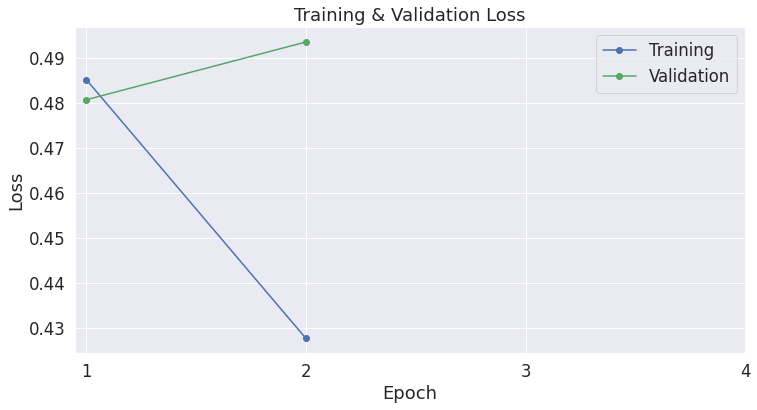

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats_bert_uncased_no_claim['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_bert_uncased_no_claim['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

## BERT base uncased - dataset with claimant

We are repeating the same steps but training and validating the model on the dataset with the claimant(source of news) and the statement combined. For this, we use the same BERT Base Uncased tokenizer.

In [ ]:
print(' Original: ', df_claim["statement"][0])
print('Tokenized: ', tokenizer.tokenize(df_claim["statement"][0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_claim["statement"][0])))

 Original:  Barack Obama: John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
Tokenized:  ['barack', 'obama', ':', 'john', 'mccain', 'opposed', 'bankruptcy', 'protections', 'for', 'families', '"', 'who', 'were', 'only', 'in', 'bankruptcy', 'because', 'of', 'medical', 'expenses', 'they', 'couldn', "'", 't', 'pay', '.', '"']
Token IDs:  [13857, 8112, 1024, 2198, 19186, 4941, 10528, 28548, 2005, 2945, 1000, 2040, 2020, 2069, 1999, 10528, 2138, 1997, 2966, 11727, 2027, 2481, 1005, 1056, 3477, 1012, 1000]


Checking the sentence length for the modified dataset.

In [ ]:
max_len = 0

for statement in df_claim["statement"]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(statement, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  118


Running the tokenization, changing the max_length parameter to 118.

In [ ]:
statements = df_claim.statement.values
our_labels = df_claim.trustIndex.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for s in statements:

    encoded_dict = tokenizer.encode_plus(
                        s,                     
                        add_special_tokens = True, 
                        max_length = 118,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',     
                   )
      
    input_ids.append(encoded_dict['input_ids']) 
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(our_labels)

print('Original: ', statements[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Barack Obama: John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
Token IDs: tensor([  101, 13857,  8112,  1024,  2198, 19186,  4941, 10528, 28548,  2005,
         2945,  1000,  2040,  2020,  2069,  1999, 10528,  2138,  1997,  2966,
        11727,  2027,  2481,  1005,  1056,  3477,  1012,  1000,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  

Creating training and validation datasets with 80-20 proportions.

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,368 training samples
4,592 validation samples


Here we are creating dataloaders and defining batch size.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

We are using the same BERT Base Uncased model as in the previous step.

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,           
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Defining the optimizer (skip if it was already defined in the code above).

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Defining epochs, total training steps and a learning rate scheduler.

In [ ]:
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Model training step is triggered by the code below.

In [ ]:
seed_val = 41

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:00:23.
  Batch    80  of    574.    Elapsed: 0:00:45.
  Batch   120  of    574.    Elapsed: 0:01:08.
  Batch   160  of    574.    Elapsed: 0:01:30.
  Batch   200  of    574.    Elapsed: 0:01:52.
  Batch   240  of    574.    Elapsed: 0:02:15.
  Batch   280  of    574.    Elapsed: 0:02:37.
  Batch   320  of    574.    Elapsed: 0:02:59.
  Batch   360  of    574.    Elapsed: 0:03:22.
  Batch   400  of    574.    Elapsed: 0:03:44.
  Batch   440  of    574.    Elapsed: 0:04:06.
  Batch   480  of    574.    Elapsed: 0:04:28.
  Batch   520  of    574.    Elapsed: 0:04:51.
  Batch   560  of    574.    Elapsed: 0:05:13.

  Average training loss: 0.49
  Training epcoh took: 0:05:21

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.47
  Validation took: 0:00:27

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:00:22.
  Batch    80  of    574.    Elapsed: 0:00:45.
  Batch  

Saving the model for future uses on Google Drive.

In [ ]:
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/model_BERT_uncased_claimant" 
torch.save(model.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Displaying the model training performance.

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.47,0.77,0:05:21,0:00:27
2,0.43,0.48,0.76,0:05:19,0:00:27


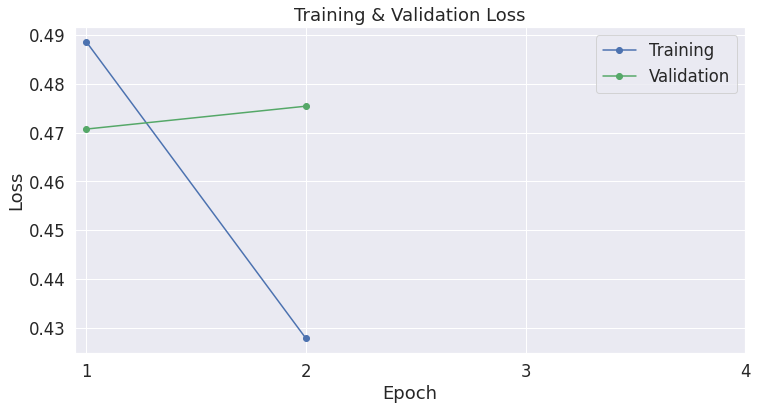

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

## BERT large uncased

Now we are repeating the same steps above but for BERT Large Uncased model. 

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
statements = df_claim.statement.values
our_labels = df_claim.trustIndex.values
input_ids = []
attention_masks = []

for s in statements:
    encoded_dict = tokenizer.encode_plus(
                        s,                      
                        add_special_tokens = True, 
                        max_length = 118,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt', 
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(our_labels)

print('Original: ', statements[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Barack Obama: John McCain opposed bankruptcy protections for families "who were only in bankruptcy because of medical expenses they couldn't pay."
Token IDs: tensor([  101, 13857,  8112,  1024,  2198, 19186,  4941, 10528, 28548,  2005,
         2945,  1000,  2040,  2020,  2069,  1999, 10528,  2138,  1997,  2966,
        11727,  2027,  2481,  1005,  1056,  3477,  1012,  1000,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,368 training samples
4,592 validation samples


In [ ]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased", 
    num_labels = 2,          
    output_attentions = False, 
    output_hidden_states = False,
)
model.cuda()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 2

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
seed_val = 44

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):   
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:01:22.
  Batch    80  of    574.    Elapsed: 0:02:41.
  Batch   120  of    574.    Elapsed: 0:04:01.
  Batch   160  of    574.    Elapsed: 0:05:21.
  Batch   200  of    574.    Elapsed: 0:06:41.
  Batch   240  of    574.    Elapsed: 0:08:00.
  Batch   280  of    574.    Elapsed: 0:09:20.
  Batch   320  of    574.    Elapsed: 0:10:40.
  Batch   360  of    574.    Elapsed: 0:11:59.
  Batch   400  of    574.    Elapsed: 0:13:19.
  Batch   440  of    574.    Elapsed: 0:14:39.
  Batch   480  of    574.    Elapsed: 0:15:58.
  Batch   520  of    574.    Elapsed: 0:17:18.
  Batch   560  of    574.    Elapsed: 0:18:37.

  Average training loss: 0.50
  Training epcoh took: 0:19:05

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.48
  Validation took: 0:01:38

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    574.    Elapsed: 0:01:20.
  Batch    80  of    574.    Elapsed: 0:02:39.
  Batch  

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/My Drive/model_BERT_large_uncased" 
torch.save(model.state_dict(), path)

In [ ]:
pd.set_option('precision', 2)
df_stats_bert_large = pd.DataFrame(data=training_stats)
df_stats_bert_large = df_stats_bert_large.set_index('epoch')
df_stats_bert_large

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.48,0.75,0:19:05,0:01:38
2,0.43,0.48,0.74,0:19:01,0:01:37


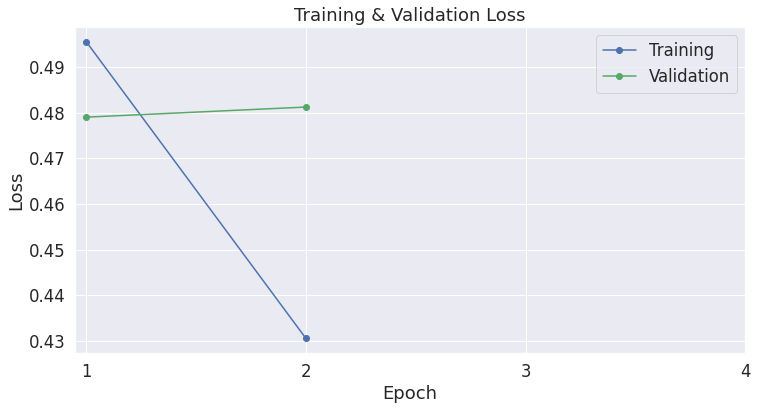

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats_bert_large['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats_bert_large['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

#Model Replicating

This code is used only if we need to use the model in a different runtime.

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=2)
path = "/content/gdrive/My Drive/model_BERT_large_uncased" 
model.load_state_dict(torch.load(path))
model_name = "bert-large-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)
max_length = 118

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

#Predictions

Below are the functions that help us make predictions based on our model and add them to our RSS dataset.

In [ ]:
def get_prediction(text, convert_to_label=True):
    # transform the statement into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to the model
    outputs = model(**inputs)
    # retrieve output probabilities 
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    d = {
        0: "trust",
        1: "no trust"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

def add_prediction_to_df(dataframe):
  dataframe["prediction"] = None
  dataframe["prediction"] = dataframe["statement"].apply(get_prediction)

def get_date(datetime):
  return datetime.date()

def add_date_from_datetime(dataframe):
  dataframe["date"] = None
  dataframe["date"] = dataframe["published"].apply(get_date)

In [ ]:
df_rss["title"] = df_rss["title"].astype(str)
df_rss["source"] = df_rss["source"].astype(str)
df_rss["published"] = pd.to_datetime(df_rss["published"], format="%Y-%m-%d", utc=True)
df_rss['statement'] = df_rss["source"] + ": " + df_rss["title"]

Here we apply these functions to our RSS dataframe.

In [ ]:
add_date_from_datetime(df_rss)
add_prediction_to_df(df_rss)

In [ ]:
df_rss.reset_index(inplace = True, drop = True)

The final table with predictions looks as follows.

In [ ]:
df_rss.head(5)

,title,published,source,statement,date,prediction
0,Is Gibraltar stuck between a rock and a hard p...,2023-01-25 15:52:40+00:00,bbc,bbc: Is Gibraltar stuck between a rock and a h...,2023-01-25,no trust
1,PMQs in 70 secs: Starmer and SNP turn up heat ...,2023-01-25 15:19:27+00:00,bbc,bbc: PMQs in 70 secs: Starmer and SNP turn up ...,2023-01-25,no trust
2,Is UK inflation going to keep falling?,2022-12-14 13:13:12+00:00,bbc,bbc: Is UK inflation going to keep falling?,2022-12-14,no trust
3,Political tensions rise over Teesside crab deaths,2023-01-11 22:50:17+00:00,bbc,bbc: Political tensions rise over Teesside cra...,2023-01-11,no trust
4,Wish You Were (Not) Here: Pink Floyd's Waters ...,2023-02-08 20:30:00+00:00,msk times,msk times: Wish You Were (Not) Here: Pink Floy...,2023-02-08,no trust


In [ ]:
df_rss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   title       493 non-null    object             
 1   published   493 non-null    datetime64[ns, UTC]
 2   source      493 non-null    object             
 3   statement   493 non-null    object             
 4   date        493 non-null    object             
 5   prediction  493 non-null    object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 23.2+ KB


In [ ]:
df= df_rss.copy()

#Dash

Below is the code used to create an application in Dash. Firstly, we define the figures we would like to show, applying colors, adding functions that will help us to create desired visualizations. Then we compose the dashboard's layout using Python with the Dash HTML type of code.

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app_color = {"graph_bg": "#082255", "graph_line": "#007ACE", "text":"#FFFFFF"}
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
server = app.server

## Table
df_for_table = df[['published', 'title', 'prediction', 'source']].copy()
df_for_table['published'] = pd.to_datetime(df_for_table['published']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_for_table.rename(columns={col: col.capitalize() for col in df_for_table.columns}, inplace=True)


## Prediction bar chart
bar_color = {"graph_bg": "#082255", "graph_line": "#007ACE"}
df_grouped = df[['date', 'prediction']].copy()
df_grouped['count'] = 1
df_grouped = df_grouped.groupby(['date', 'prediction']).count().reset_index()
days_to_show = 7
df_grouped = df_grouped[pd.to_datetime(df_grouped.date, errors='coerce') >= datetime.today() - timedelta(days=days_to_show)].reset_index()
prediction_bar_chart = px.bar(df_grouped, x='date', y='count', color='prediction', 
             color_discrete_map = {'trust':'green', 'no trust':'#082255'},
             title="Amount of trustworthy and untrustworthy news during last 7 days")
prediction_bar_chart.update_layout(title={'x':0.5})

## Pie chart
df_pie = df[['source', 'prediction']].copy()
df_pie['count'] = 1
df_pie = df_pie.groupby(['source', 'prediction']).count().reset_index()
df_pie = df_pie.drop(df_pie[df_pie.prediction == "trust"].index).reset_index(drop=True)
pie = px.pie(df_pie, values='count', names='source', color='source',
             color_discrete_map = {'bbc':'#082255', 'cnn':'#007ACE', 'skynews':'black', 'foxnews':'blue'},
             title = "Share of 'no trust' news per media source")
pie.update_layout(title={'x':0.5})

## Heat map
def calculate_time_span(span):
  if 0 <= span < 6:
    return 1;
  elif 6 <= span < 12:
    return 2;
  elif 12 <= span < 18:
    return 3;
  elif 18 <= span < 24:
    return 4;

def get_data_for_heatmap(input_dataframe, days):
  input_dataframe = input_dataframe.drop(input_dataframe[input_dataframe.prediction == "trust"].index).reset_index().drop('index', axis = 1)
  input_dataframe['hour_span'] = input_dataframe.apply(lambda row: calculate_time_span(row.published.hour), axis = 1)

  # show data only for last days
  days_to_show_heat_map = days
  input_dataframe = input_dataframe[pd.to_datetime(input_dataframe.date, errors='coerce') >= datetime.today() - timedelta(days=days_to_show_heat_map)]
  input_dataframe = input_dataframe.drop(['published', 'prediction'], axis = 1)
  input_dataframe['fake_count'] = 1
  input_dataframe = input_dataframe.groupby(['date', 'hour_span']).count().reset_index()
  input_dataframe_list = input_dataframe.set_index(['date','hour_span'])['fake_count'].unstack(fill_value=0).reset_index().values.tolist()

  for x in input_dataframe_list:
      del x[0]

  return input_dataframe_list;

heat_map_data = get_data_for_heatmap(df[['published', 'date', 'prediction']].copy(), 7)


heat_map_figure = px.imshow(heat_map_data,
                            labels=dict(x="Hours", y="Date", color="Number of fake news"),
                            x=['00:00-5:00', '6:00-11:00', '12:00-17:00', '18:00-23:00'],
                            y=['6 days ago', '5 days ago', '4 days ago', '3 days ago', '2 days ago', 'Yesterday', 'Today'],
                            aspect='auto',
                            title = "Heatmap of unreliable news during the day",
                            color_continuous_scale ='dense')

heat_map_figure.update_xaxes(side="top")
heat_map_figure.update_layout(title={'x':0.5, 'y':0.98})


## Source bar chart
df_source_bar_chart = df.groupby(['source', 'prediction']).count().reset_index()
source_bar_chart = px.bar(df_source_bar_chart, x="source", y="statement", color = "prediction",  color_discrete_map = {'trust':'green', 'no trust':'#082255'}, title ="Amount of 'no trust' news per media source")
source_bar_chart.update_layout(title={'x':0.5})

## Bigram
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  
    text = str(text).replace(r'[^\.\w\s]', ' ') 
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ')
    text = text.lower().strip()
    #text = ' '.join(text)    
    return text

# Nltk Preprocessing
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return text

df_grams = df.copy()
df_grams["title"] = df_grams.title.apply(nltk_preprocess)
fake_n = ' '.join(df_grams[df_grams['prediction']=='no trust']['title'])

bigram_data = (pd.Series(nltk.ngrams(fake_n.split(), 2)).value_counts())[:20]
bigram_frame = bigram_data.to_frame().reset_index()
bigram_frame = bigram_frame.rename(columns= {0: 'count_fakes', 'index': 'combinations'})
bigram_frame= bigram_frame.sort_values(['count_fakes'], ascending=True) 
bigram_frame.index.name = 'index'
bigram_frame['combinations'] =  bigram_frame['combinations'].astype('str') 

bigram_fig = px.bar(bigram_frame, x='count_fakes', y='combinations', title = "Bigram of most frequent words in 'no trust' news")
bigram_fig.update_layout(title={'x':0.5})
bigram_fig.update_traces(marker_color='#082255')

# Trigram
trigram_data = (pd.Series(nltk.ngrams(fake_n.split(), 3)).value_counts())[:20]
trigram_frame = trigram_data.to_frame().reset_index()
trigram_frame = trigram_frame.rename(columns= {0: 'count_fakes', 'index': 'combinations'})
trigram_frame= trigram_frame.sort_values(['count_fakes'], ascending=True) 
trigram_frame.index.name = 'index'
trigram_frame['combinations'] =  trigram_frame['combinations'].astype('str') 

trigram_fig = px.bar(trigram_frame, x='count_fakes', y='combinations', title = "Trigram of most frequent words in 'no trust' news")
trigram_fig.update_layout(title={'x':0.5})
trigram_fig.update_traces(marker_color='#082255')


##  APP STARTS HERE   ##


app.layout =  html.Div(
                       [
    
html.Div(className='container-fluid', children=[html.H2('Real Time News Trustworthiness Analysis', style={'color':"#082255"})]),
                 


 html.Div([
      html.P('This dashboard provides a high-level analysis of  '
      'online news retrieved from different sources and their trustworthiness. '
      'Each news is assigned with a trustIndex label: '
      'trust and no trust. '
      'Trust label means that the news was verified by the natural language processing alogrithm and it can be trusted'
      ' No trust label means that the news cannot be trusted according to the prediction made by the model.'
      )
          ],
          className="header__info pb-20",
      ),


    html.Div(className='row', children=[html.Div(
        dcc.Graph(id='prediction-bar-chart', figure=prediction_bar_chart, animate=False), 
        )], style={'width':'98%','margin-left':10,'margin-right':10, 'margin-bottom':50, 'max-width':50000}),
      
        
    html.Div(className='table-news-heatmap', children=[
        html.Div(className='table-news', children=[
                
            dbc.Container([
              dbc.Label('Prediction of news trustworthiness',
                        style={
                                'text-align':'center', 
                                'color':'#082255', 
                                'font-size':17,
                                'font-family':'verdana',
                                'margin-bottom':40
                              }),
              dash.dash_table.DataTable(
                                        df_for_table.to_dict('records'),
                                        style_table={'height':'850px', 'overflowY': 'auto',},
                                        style_data={'whiteSpace': 'normal'},
                                        style_header={
                                            'color':app_color['text'],
                                            'backgroundColor': '#082255',
                                            'fontWeight': 'bold',
                                            'font-family': 'Helvetica',
                                        },
                                        style_cell={
                                            'textAlign': 'left',
                                            'font-family': 'Helvetica',
                                            'padding':'12px 12px',
                                            },
                                        style_cell_conditional=[
                                            {'if': {'column_id': 'Published'},
                                            'width': '10%'},
                                            {'if': {'column_id': 'Title'},
                                            'width': '70%'},
                                            {'if': {'column_id': 'Prediction'},
                                            'width': '10%'},
                                            {'if': {'column_id': 'Source'},
                                            'width': '10%'},
                                        ],
                                        style_as_list_view=True,
                                        page_size=50
                                        )
            ], fluid=True),

        ], style={'flex': 1, 'width':'50%', 'margin-right':20}),
        
        
        html.Div(className='pie-heatmap', children=[
            html.Div(
                dcc.Graph(id='pie-graph', figure=pie, animate=False), 
                style={'width':'90%'}
            ),
            html.Div(
                dcc.Graph(id='heatmap', figure=heat_map_figure, animate=False), 
                style={'width':'90%'}
            )

        ], style={'flex': 1, 'width':'50%', 'margin-left':20})
        
    ],
    style = {'display': 'flex', 'flex-direction': 'row'}
    ),

    
    html.Div(className='row', children=[
        html.Div(
          dcc.Graph(id='source-bar-chart', figure=source_bar_chart, animate=False)
        )
    ], style={'width':'98%','margin-left':10,'margin-right':10,'max-width':50000}),

    html.Div(className='row', children=[
        html.Div(
          dcc.Graph(id='bigram', figure=bigram_fig, animate=False), 
          style={'width':'48%'}
        ),
        html.Div(
          dcc.Graph(id='trigram', figure=trigram_fig, animate=False), 
          style={'width':'48%'}
        )
        ], style = {'display': 'flex', 'flex-direction': 'row'})

], style={'margin-top':'30px'})



To run the app on our local server, we use this code:

In [ ]:
app.run_server(debug=True)

Dash app running on:


<IPython.core.display.Javascript object>

We would like to put our application online. For this we are going to use ngrok, which is a tool that helps to run an appllication on the internet and share with others. In order to run the app, we need to sign up at ngrok and get an authentication token. The link: https://dashboard.ngrok.com/get-started/your-authtoken

Run this code and enter your token.

In [ ]:
token = getpass('Enter the ngrok token value: ')

This step terminates ngrok tunnels, if any are open and sets the auth token.

In [ ]:
ngrok.kill()
ngrok.set_auth_token(token)

This code generates a link where the application can be accessed online by other users for testing and feedback.

In [ ]:
ngrok.connect(8050)

<NgrokTunnel: "http://a145-34-124-147-214.ngrok.io" -> "http://localhost:8050">